Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

dataroot = '../WaterLevelPrediction_SelectingModel//Data/'

In [7]:
!nvidia-smi

Mon Jan 15 20:02:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.33                 Driver Version: 546.33       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0              N/A / ERR! |    603MiB /  4096MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Load the data

In [2]:
df = pd.read_pickle(dataroot+'finaldata.pkl')

Time Series Cross Validation

In [3]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=6, test_size=365)
df = df.sort_index()

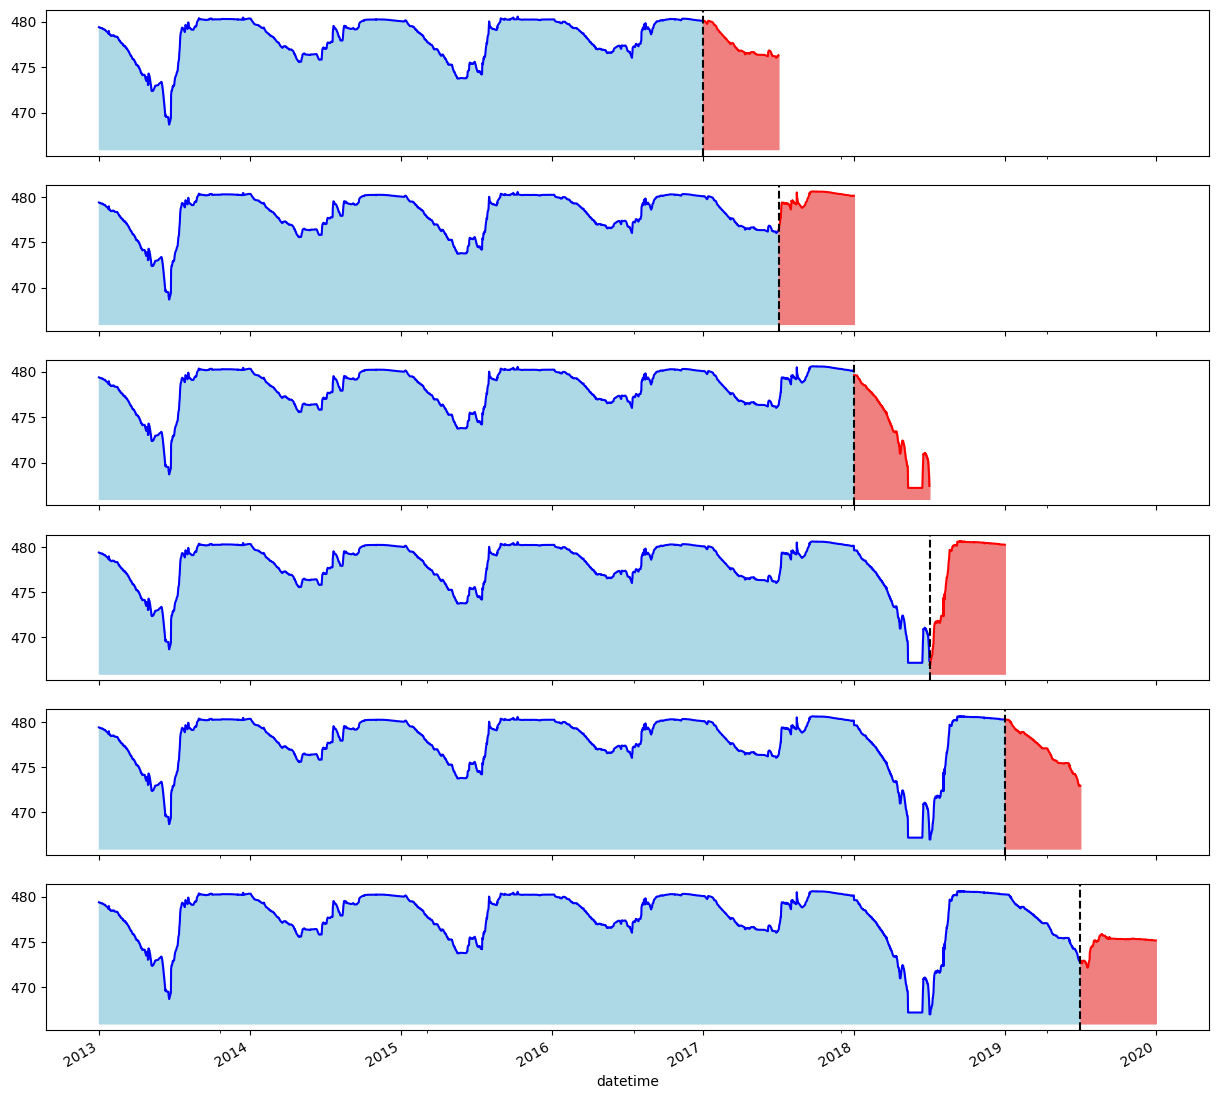

In [4]:
fig, axs = plt.subplots(6,1, figsize = (15,15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['water_level'].plot(ax=axs[fold],
                              label='Tập huấn luyện',
                              color='blue')
    test['water_level'].plot(ax=axs[fold],
                             label='Tập kiểm thử',
                             color='red')
    axs[fold].fill_between(train.index,466, train['water_level'], color='lightblue')
    axs[fold].fill_between(test.index,466, test['water_level'], color='lightcoral')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold+=1
plt.show()

Train the model with first features set

In [24]:
from xgboost import XGBRegressor

fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(device = 'cuda:0')
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:2.18395	validation_1-rmse:1.62921
[1]	validation_0-rmse:2.15159	validation_1-rmse:1.71094
[2]	validation_0-rmse:2.13323	validation_1-rmse:1.78115


[3]	validation_0-rmse:2.12095	validation_1-rmse:1.83329
[4]	validation_0-rmse:2.11480	validation_1-rmse:1.87252
[5]	validation_0-rmse:2.10911	validation_1-rmse:1.90137
[6]	validation_0-rmse:2.10239	validation_1-rmse:1.92081
[7]	validation_0-rmse:2.09844	validation_1-rmse:1.93430
[8]	validation_0-rmse:2.09572	validation_1-rmse:1.94142
[9]	validation_0-rmse:2.09378	validation_1-rmse:1.94043
[10]	validation_0-rmse:2.09119	validation_1-rmse:1.94744
[11]	validation_0-rmse:2.09015	validation_1-rmse:1.95010
[12]	validation_0-rmse:2.08925	validation_1-rmse:1.95335
[13]	validation_0-rmse:2.08754	validation_1-rmse:1.95570
[14]	validation_0-rmse:2.08697	validation_1-rmse:1.95600
[15]	validation_0-rmse:2.08559	validation_1-rmse:1.95548
[16]	validation_0-rmse:2.08421	validation_1-rmse:1.95811
[17]	validation_0-rmse:2.08379	validation_1-rmse:1.95747
[18]	validation_0-rmse:2.08302	validation_1-rmse:1.95758
[19]	validation_0-rmse:2.08284	validation_1-rmse:1.95769
[20]	validation_0-rmse:2.08251	validat

Score

In [25]:
print(f'mean squared error across folds:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across folds:{np.mean(maes)}')
print(f'score for each folds:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each folds:{r2s}')

mean squared error across folds:3.2220858573653612
score for each fold:[1.976552261348326, 1.6055992585929753, 6.332849007588943, 3.909559735258587, 2.3395783291198042, 3.1683765522835325]
mean absolute error across folds:2.7055386026460835
score for each folds:[1.7290436911386973, 1.4438088479238016, 4.845743521912458, 3.251590067824272, 1.9695118358037254, 2.9935336512735464]
r2 score across fold:-2.9228263454582706
score for each folds:[-1.1357176914769167, -3.1088653369091057, -1.2239227052504176, 0.0034879657584431234, -0.4476099058528178, -11.624330399018808]


Create Lag Feature

In [26]:
def add_lag(df):
    target_map = df['water_level'].to_dict() #mapping water level
    df['lag'] = (df.index - pd.Timedelta('12 hours')).map(target_map)
    return df

df = add_lag(df)

In [27]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=100,
                           device = "cuda:0")
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:1.58330	validation_1-rmse:1.07314
[1]	validation_0-rmse:1.12160	validation_1-rmse:0.75302
[2]	validation_0-rmse:0.79874	validation_1-rmse:0.53111
[3]	validation_0-rmse:0.57030	validation_1-rmse:0.37456
[4]	validation_0-rmse:0.40978	validation_1-rmse:0.26395


[5]	validation_0-rmse:0.29797	validation_1-rmse:0.18757
[6]	validation_0-rmse:0.22057	validation_1-rmse:0.13710
[7]	validation_0-rmse:0.16753	validation_1-rmse:0.10191
[8]	validation_0-rmse:0.13035	validation_1-rmse:0.07903
[9]	validation_0-rmse:0.10545	validation_1-rmse:0.06548
[10]	validation_0-rmse:0.08960	validation_1-rmse:0.05924
[11]	validation_0-rmse:0.07954	validation_1-rmse:0.05548
[12]	validation_0-rmse:0.07302	validation_1-rmse:0.05331
[13]	validation_0-rmse:0.06855	validation_1-rmse:0.05208
[14]	validation_0-rmse:0.06542	validation_1-rmse:0.05221
[15]	validation_0-rmse:0.06292	validation_1-rmse:0.05149
[16]	validation_0-rmse:0.06115	validation_1-rmse:0.05098
[17]	validation_0-rmse:0.05941	validation_1-rmse:0.05065
[18]	validation_0-rmse:0.05828	validation_1-rmse:0.05206
[19]	validation_0-rmse:0.05766	validation_1-rmse:0.05246
[20]	validation_0-rmse:0.05668	validation_1-rmse:0.05256
[21]	validation_0-rmse:0.05588	validation_1-rmse:0.05265
[22]	validation_0-rmse:0.05507	valid

In [28]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.3125972671290628
score for each fold:[0.06487752196068902, 0.15154364390759767, 1.0679990352947553, 0.42333078959438897, 0.08717571033820683, 0.08065690167873876]
mean absolute error across fold:0.18074384074450744
score for each fold:[0.03398572279002733, 0.09465869809503442, 0.5937169607502162, 0.2744496702429373, 0.03836144517872355, 0.04929054741010575]
r2 score across fold:0.9793283565915026
score for each fold:[0.9976990046119973, 0.9633964639798118, 0.9367496194451047, 0.9883161343475911, 0.9979901328311467, 0.9918187843333636]


Hyperparameters tuning

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'eta': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 10],
    'subsample': [0.5, 0.7, 1.0],
    'gamma':[0, 0.1, 0.2, 0.3]
}

xgb_reg = XGBRegressor(device = 'cuda:0')
grid_search = GridSearchCV(estimator=xgb_reg, 
                           param_grid=param_grid,
                           cv=tss)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=365),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device='cuda:0',
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None,...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'eta': [0.01, 0.05, 0.1, 0.2],
                         'gamma': [0, 0.1, 0.2, 0.3], 'max_depth': [3, 6, 10],
                         'n_estimators': [100, 200, 500],
                         'subsample': [0.5, 0.7, 1.0]})

In [30]:
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'eta': 0.2, 'gamma': 0, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.7}


In [44]:
fold = 0
preds = []
rmses = []
maes = []
r2s = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    features = ['precipitation','sluice_status','lag']
    target = 'water_level'
    
    X_train = train[features]
    y_train = train[target]
    
    X_test = test[features]
    y_test = test[target]
    
    xgb_reg = XGBRegressor(n_estimators=best_params['n_estimators'],
                           learning_rate=best_params['eta'],
                           max_depth=best_params['max_depth'],
                           subsample = best_params['subsample'],
                           gamma = best_params['gamma'],
                           early_stopping_rounds=10,
                           device = 'cuda:0')
    xgb_reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train),(X_test, y_test)],
        verbose=True)
    
    y_pred = xgb_reg.predict(X_test)
    preds.append(y_pred)
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    rmses.append(rmse)
    mae = mean_absolute_error(y_test,y_pred)
    maes.append(mae)
    r2 = r2_score(y_test,y_pred)
    r2s.append(r2)

[0]	validation_0-rmse:1.81190	validation_1-rmse:1.20223
[1]	validation_0-rmse:1.46551	validation_1-rmse:0.98982
[2]	validation_0-rmse:1.18598	validation_1-rmse:0.81601
[3]	validation_0-rmse:0.96036	validation_1-rmse:0.66696
[4]	validation_0-rmse:0.77900	validation_1-rmse:0.53447


[5]	validation_0-rmse:0.63578	validation_1-rmse:0.42594
[6]	validation_0-rmse:0.52297	validation_1-rmse:0.33726
[7]	validation_0-rmse:0.43367	validation_1-rmse:0.26760
[8]	validation_0-rmse:0.36347	validation_1-rmse:0.21223
[9]	validation_0-rmse:0.30813	validation_1-rmse:0.17298
[10]	validation_0-rmse:0.26701	validation_1-rmse:0.14177
[11]	validation_0-rmse:0.23632	validation_1-rmse:0.12036
[12]	validation_0-rmse:0.21385	validation_1-rmse:0.10146
[13]	validation_0-rmse:0.19733	validation_1-rmse:0.08888
[14]	validation_0-rmse:0.18467	validation_1-rmse:0.07594
[15]	validation_0-rmse:0.17589	validation_1-rmse:0.07080
[16]	validation_0-rmse:0.16841	validation_1-rmse:0.06593
[17]	validation_0-rmse:0.16152	validation_1-rmse:0.06285
[18]	validation_0-rmse:0.16000	validation_1-rmse:0.05962
[19]	validation_0-rmse:0.15689	validation_1-rmse:0.05889
[20]	validation_0-rmse:0.14631	validation_1-rmse:0.05815
[21]	validation_0-rmse:0.13656	validation_1-rmse:0.05813
[22]	validation_0-rmse:0.13672	valid

In [45]:
print(f'mean squared error across fold:{np.mean(rmses)}')
print(f'score for each fold:{rmses}')
print(f'mean absolute error across fold:{np.mean(maes)}')
print(f'score for each fold:{maes}')
print(f'r2 score across fold:{np.mean(r2s)}')
print(f'score for each fold:{r2s}')

mean squared error across fold:0.28320414219875417
score for each fold:[0.05657272247719502, 0.16803947583176165, 0.9973558253911795, 0.3118226109353072, 0.07247984748298797, 0.09295437107409371]
mean absolute error across fold:0.17240875829409222
score for each fold:[0.04476791256421315, 0.11283620170697806, 0.567084238548803, 0.1858440576840757, 0.05650297985338097, 0.0674171594071028]
r2 score across fold:0.9799149933927732
score for each fold:[0.9982503894068798, 0.9549940196245493, 0.9448403274505609, 0.9936606891422891, 0.9986106524231415, 0.9891338823092187]


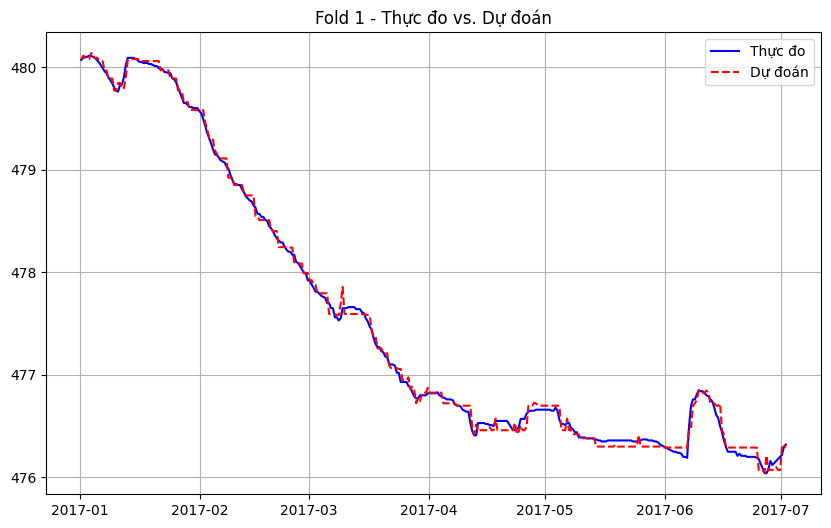

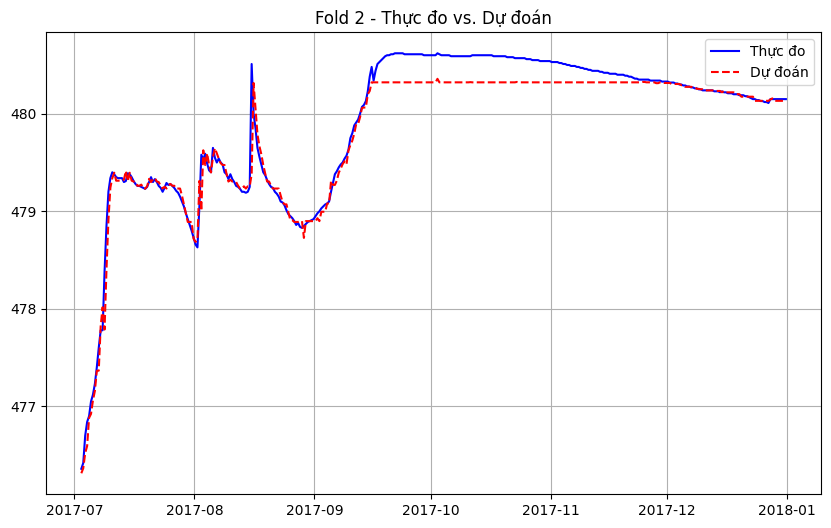

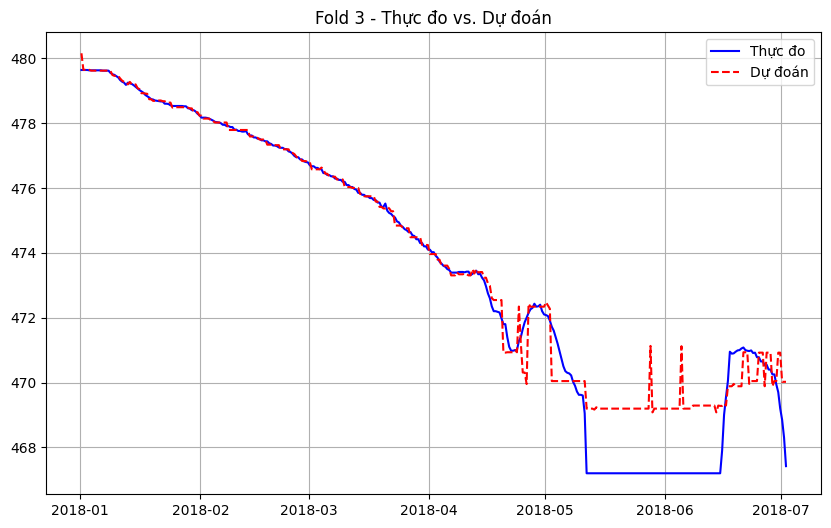

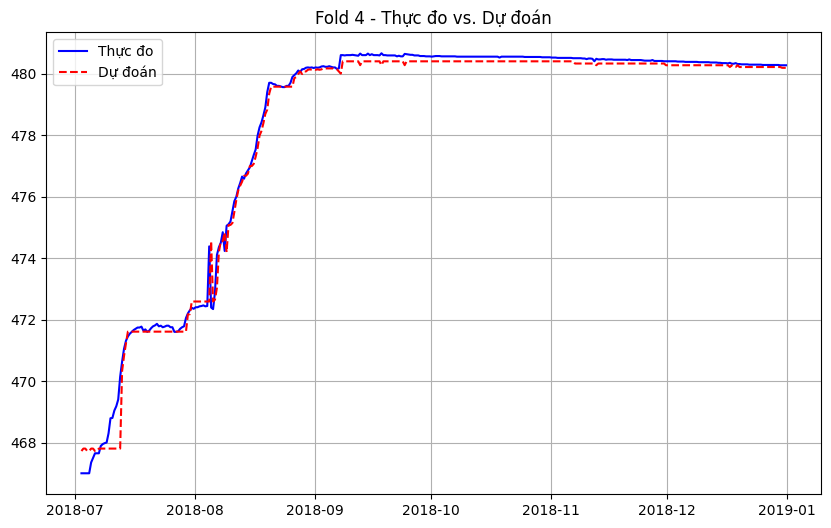

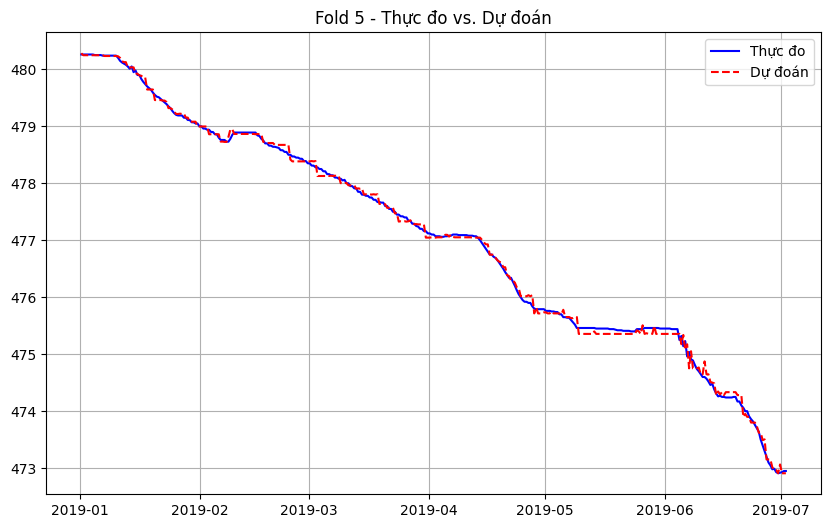

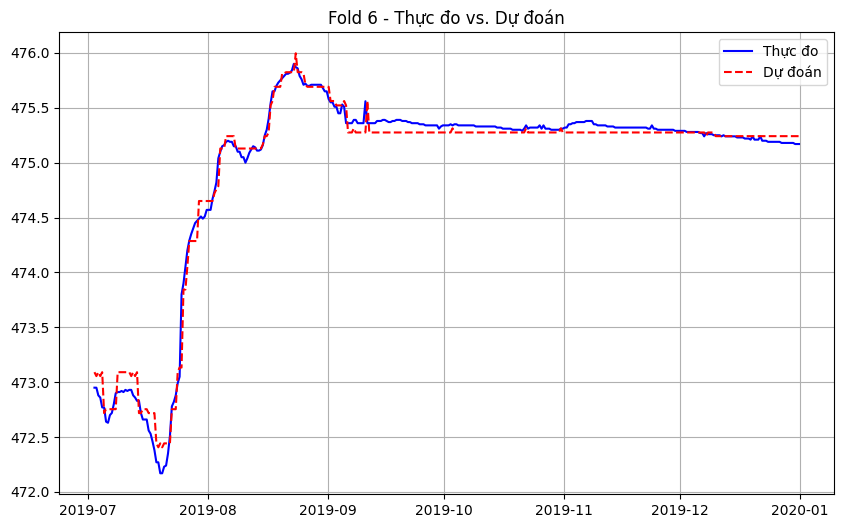

In [46]:
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['water_level'], label='Thực đo', color='blue')
    plt.plot(test.index, preds[fold], label='Dự đoán', color='red', linestyle='dashed')
    fold += 1

    plt.title('Fold {} - Thực đo vs. Dự đoán'.format(fold))

    plt.legend()
    plt.grid()
    plt.show()

In [50]:
input_data = {
    'precipitation': [27,49,26],
    'sluice_status': [0,0,0],
    'lag': [471.8,472.35,473.15]
}

input_df = pd.DataFrame(input_data)

predictions = xgb_reg.predict(input_df)

# Round the predictions to 2 decimal places
predictions = [round(pred, 2) for pred in predictions]

print(predictions)

[471.93, 472.44, 473.18]
